![ewatercycle logo](https://raw.githubusercontent.com/eWaterCycle/ewatercycle/main/docs/examples/logo.png)

## Case study 2: Replace internal evaporation module of PCRGlobWB2.0 with external data source
This notebooks demonstrates how to use eWaterCycle to 'interfere' in a model. Every timestep, the evaporation of PCRGlobWB is 'corrected' to reflect the evaporation as measured by FLuxnet data. In this way, the model is forced by both precipitation and evaporation. Since we are only using one (point) measurement as 'the evaporation' of the entire basin, this (of course) leads to a rather different prediction for discharge. Which one is 'better' is, as always, in the eye of the beholder.

## Import statements
We'll be using the following modules

In [14]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [15]:
# Calculations and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Cartography (drawing maps)
from cartopy import crs, feature as cfeature

# eWaterCycle specific
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.parameter_sets
import ewatercycle.observation.grdc

## List of files created for this experiment

### for PCRGlobWB2.0

- `merrimack_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 



## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment

In [16]:
grdc_station_id = '4147380'
grdc_latitude = 42.6459
grdc_longitude = -71.2984

# Determined earlier in an exploratory experiment
model_latitude = 42.63
model_longitude = -71.29

## Import GRDC observations

We will use GRDC station data to verify the model output. 
Read the GRDC data for the period of the experiment, for the station given above. If you are not on jupyter.ewatercycle.org or cartesius, follow the instructions about [download-observation-data](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#download-observation-data) on our [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#) documentation page. 

In [17]:
observations, metadata = ewatercycle.observation.grdc.get_grdc_data(grdc_station_id, start_time='2002-01-01T00:00:00Z', end_time='2002-12-31T00:00:00Z')
discharge_data = observations.rename(columns = {'streamflow': 'GRDC'})
discharge_data.head()

GRDC station 4147380 is selected. The river name is: MERRIMACK RIVER.The coordinates are: (42.6459, -71.2984).The catchment area in km2 is: 12004.7. There are 0 missing values during 2002-01-01T00:00:00Z_2002-12-31T00:00:00Z at this station. See the metadata for more information.


,GRDC
time,
2002-01-01,56.067
2002-01-02,54.085
2002-01-03,48.988
2002-01-04,50.121
2002-01-05,47.572


In [18]:
# Add columns for the data and fill them with NaN.
# We will add data to these columns as we run the model experiments
discharge_data['reference'] = np.nan
discharge_data['experiment'] = np.nan
discharge_data.head()

,GRDC,reference,experiment
time,,,
2002-01-01,56.067,NaN,NaN
2002-01-02,54.085,NaN,NaN
2002-01-03,48.988,NaN,NaN
2002-01-04,50.121,NaN,NaN
2002-01-05,47.572,NaN,NaN


## Loading parameter set

In [19]:
parameterset = ewatercycle.parameter_sets.ParameterSet(
    name="merrimack_parameterset",
    directory="/mnt/data/examples/technical_paper/pcr-globwb/input",
    config="/mnt/data/examples/technical_paper/pcr-globwb/input/merrimack_05min_era5.ini",
    target_model="pcrglobwb",
    doi="10.5281/zenodo.1045339",
    supported_model_versions={"setters"},
)

print(parameterset)

Parameter set
-------------
name=merrimack_parameterset
directory=/mnt/data/examples/technical_paper/pcr-globwb/input
config=/mnt/data/examples/technical_paper/pcr-globwb/input/merrimack_05min_era5.ini
doi=10.5281/zenodo.1045339
target_model=pcrglobwb
supported_model_versions={'setters'}


## Setting up the model objects

In [41]:
# Start up a container for PCRGlob for the reference run and initialize using the setting file
reference = ewatercycle.models.PCRGlobWB(version="setters", parameter_set=parameterset)
reference_config, reference_dir = reference.setup()
print(reference_config, reference_dir)
reference.initialize(reference_config)

/mnt/home/user36/temp/Case2/pcrglobwb_20210722_123622/pcrglobwb_ewatercycle.ini /mnt/home/user36/temp/Case2/pcrglobwb_20210722_123622


In [43]:
# Start up a container for PCRGlob for the experiment run and initialize using the setting file
experiment = ewatercycle.models.PCRGlobWB(version="setters", parameter_set=parameterset)
experiment_config, experiment_dir = experiment.setup()
print(experiment_config, experiment_dir)
experiment.initialize(experiment_config)

/mnt/home/user36/temp/Case2/pcrglobwb_20210722_142415/pcrglobwb_ewatercycle.ini /mnt/home/user36/temp/Case2/pcrglobwb_20210722_142415


# Importing evaporation data from Fluxnet

In [23]:
# Read the csv file downloaded from [TODO]
fluxnetData = pd.read_csv('/mnt/home/user37/technicalPaperExampleNotebooks/FLX_US-Ha1_FLUXNET2015_SUBSET_DD_1991-2012_1-4.csv')
fluxnetData['Datetime'] = pd.to_datetime(fluxnetData['TIMESTAMP'], format='%Y%m%d')
fluxnetData = fluxnetData.set_index('Datetime')

# Select evaporation measured as latent heat flux from fluxnetdata
# and rewrite evaporation from latent heat flux to m/day
fluxnet_evaporation = fluxnetData['LE_F_MDS'] / (2.43 * 1000000) * 6772 ** 2 / (3600 * 24) 

We will apply a correction to the model state based on this fluxnet data. This is done by calling the function below.

In [24]:
def apply_fluxnet_correction(model, fluxnet_evap):
    """Adjust soil moisture and channel storage based on measured evaporation."""
    
    # Read out model data
    land_surface_evaporation = model.get_value_as_xarray('land_surface_evaporation')
    bare_soil_evaporation = model.get_value_as_xarray('bare_soil_evaporation')
    upper_soil_storage = model.get_value_as_xarray('upper_soil_storage')
    upper_soil_saturation_degree = model.get_value_as_xarray('upper_soil_saturation_degree')
    channel_storage = model.get_value_as_xarray('channel_storage')

    # Determine a correction factor by comparing mean land surface evaporation to fluxnet evaporation
    time = land_surface_evaporation.time.dt.strftime('%Y-%m-%d').item()
    correction_factor = (fluxnet_evap[time] / land_surface_evaporation.mean()).item()

    # Apply the correction factor to bare soil evaporation in the model
    corrected_bare_soil_evaporation = bare_soil_evaporation * correction_factor
    evaporation_adjustment = corrected_bare_soil_evaporation - bare_soil_evaporation

    # Apply the same absolute correction to upper soil storage 
    corrected_upper_soil_storage = upper_soil_storage - evaporation_adjustment # PK: this was +, but I think it should be -

    # Determine whether there is an excess or deficit
    maximum_upper_soil_storage =  (1 / upper_soil_saturation_degree) * upper_soil_storage
    excess = corrected_upper_soil_storage > maximum_upper_soil_storage
    deficit = corrected_upper_soil_storage < 0

    # Where there is an excess, water will be added to the channel
    updated_channel_storage = channel_storage + (corrected_upper_soil_storage - maximum_upper_soil_storage)
    channel_storage = updated_channel_storage.where(excess, other=channel_storage)
    corrected_upper_soil_storage = maximum_upper_soil_storage.where(excess, other=corrected_upper_soil_storage)

    # Where there is a deficit, water will be taken from the channel
    updated_channel_storage = channel_storage + corrected_upper_soil_storage  # (note that the last term is always negative here)
    channel_storage = updated_channel_storage.where(deficit, other=channel_storage)
    corrected_upper_soil_storage = corrected_upper_soil_storage.where(~deficit, other=0)
    
    # Convert storage to saturation
    corrected_upper_soil_saturation_degree = corrected_upper_soil_storage / maximum_upper_soil_storage
    corrected_upper_soil_saturation_degree = corrected_upper_soil_saturation_degree.fillna(upper_soil_saturation_degree)
    
    # Update the running model
    model.set_value('channel_storage', channel_storage.values.flatten())
    model.set_value('upper_soil_saturation_degree', corrected_upper_soil_saturation_degree.values.flatten())

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Since both models (reference and epxeriment) do not interact, they can be run in seperate loops and (ideally) this should be done in parallel.

In [42]:
# TODO (wish): this cell and the experiment cell below have long runtimes, but are independent. Would be awesome of we could run in parallel. 
# https://github.com/eWaterCycle/ewatercycle/issues/78

print(f'Running Reference Model Run', flush=True)
while reference.time < reference.end_time:
    
    # Update the model (takes a few seconds per timestep)
    reference.update() 
    
    # Track discharge at station location
    discharge_at_station = reference.get_value_at_coords('discharge', lon=[model_longitude], lat=[model_latitude])
    
    # Add the discharge to the dataframe
    time = reference.time_as_datetime.date().strftime('%Y-%m-%d')  # needs to match the time format of the dataframe
    discharge_data['reference'][time] = discharge_at_station
    
    # Show progress
    print(f'Current time: {time}', end="\r")
          
print('\nDone')

Running Reference Model Run
Current time: 2002-12-31
Done


In [44]:
print(f'Running Experiment Model Run', flush=True)
while experiment.time < experiment.end_time:
    
    # Update the model (takes a few seconds per timestep)
    experiment.update()
    
    # Apply a correction based on fluxnet data
    apply_fluxnet_correction(experiment, fluxnet_evaporation)
    
    # Track discharge at station location
    discharge_at_station = experiment.get_value_at_coords('discharge', lon=[model_longitude], lat=[model_latitude])

    # Add the discharge to the dataframe
    time = experiment.time_as_datetime.date().strftime('%Y-%m-%d')  # needs to match the time format of the dataframe
    discharge_data['experiment'][time] = discharge_at_station
    
    # Show progress
    print(f'Current time: {time}', end="\r")  # "\r" clears the output before printing the next timestamp
          
print('\nDone')

Running Experiment Model Run
Current time: 2002-12-31
Done


## Plot the results

Show a map of the final time step:

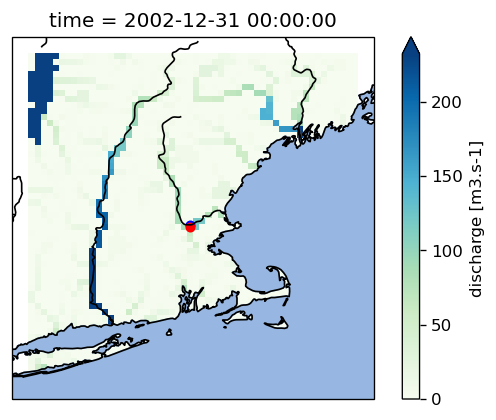

In [45]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
reference.get_value_as_xarray("discharge").plot(ax=ax, cmap='GnBu', robust=True)

# Also plot the station location
ax.scatter(grdc_longitude, grdc_latitude, s=25, c='b')
ax.scatter(model_longitude, model_latitude, s=25, c='r')

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2, color='k')
ax.coastlines(zorder=3)

fig.savefig(f'pcrglobwb_RolfCase2_discharge_map', bbox_inches='tight', dpi=300)

Plot the time series of discharge that we have traced

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

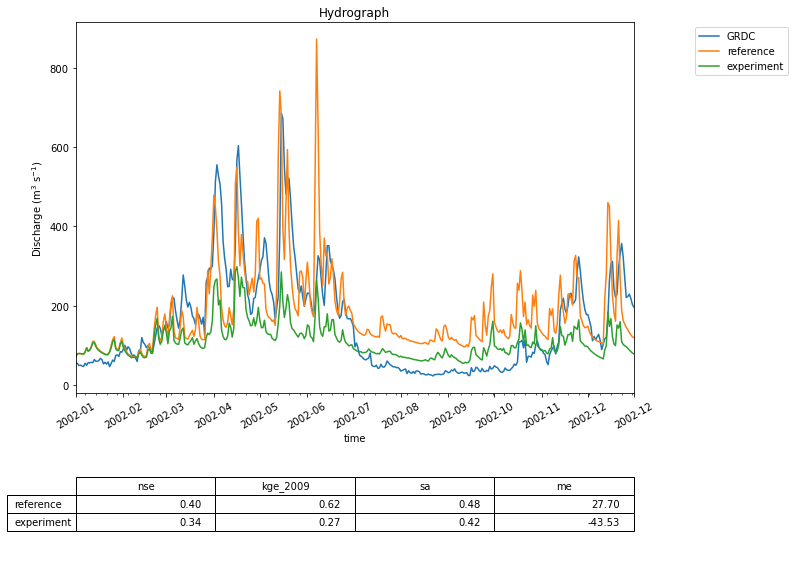

In [46]:
ewatercycle.analysis.hydrograph(discharge_data, reference='GRDC')

### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [47]:
reference.finalize()
experiment.finalize()